In [1]:
from light_curve import LightCurve
import joblib
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from torchvision import transforms

## Dataset


In [2]:
class data_LC(Dataset):
    def __init__(self,input):
        self.data = input
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]


In [3]:
path_macho = '/Users/francisco/Documents/data/macho/full.pkl'
data_macho = joblib.load(path_macho)
path_asas = '/Users/francisco/Documents/data/asas/full.pkl'
data_asas = joblib.load(path_asas)
path_linear = '/Users/francisco/Documents/data/linear/full.pkl'
data_linear = joblib.load(path_linear)

## Cargar datos

In [4]:
all_data = data_macho + data_asas + data_linear

In [5]:
for lc in all_data:
    lc.period_fold()
X = [[lc.times,lc.measurements,lc.errors] for lc in all_data]



In [6]:
max_value = max([lc.max_value() for lc in all_data])
min_value = min([lc.min_value() for lc in all_data])

In [7]:
for lc in all_data:
    lc.normalize(min_value,max_value)
    lc.period_fold()
X = [[lc.times,lc.measurements,lc.errors] for lc in all_data]



In [8]:
from keras.utils.np_utils import to_categorical
classnames, y_inds = np.unique([str(lc.label) for lc in all_data],return_inverse=True)
Y = to_categorical(y_inds, len(classnames))



2023-05-06 00:20:08.986272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
print(classnames)

['Beta_Cephei' 'Beta_Lyrae' 'Beta_Persei' 'Ceph 1st' 'Ceph Fund'
 'ChemPeculiar' 'ClassT_Tauri' 'Classical_Cepheid' 'Delta_Scuti' 'EB'
 'Ellipsoidal' 'Herbig_AEBE' 'LPV WoodA' 'LPV WoodB' 'LPV WoodC'
 'LPV WoodD' 'LSP' 'Mira' 'MultiMode_Cepheid' 'None' 'PopII_Cepheid'
 'Pulsating_Be' 'RCB' 'RRL + GB' 'RRL AB' 'RRL C' 'RRL E' 'RR_Lyrae_DM'
 'RR_Lyrae_FM' 'RR_Lyrae_FO' 'RSG' 'RS_CVn' 'RV_Tauri' 'SARG_A' 'SARG_B'
 'SX_Phe' 'S_Doradus' 'Semireg_PV' 'W_Ursae_Maj' 'Weakline_T_Tauri']


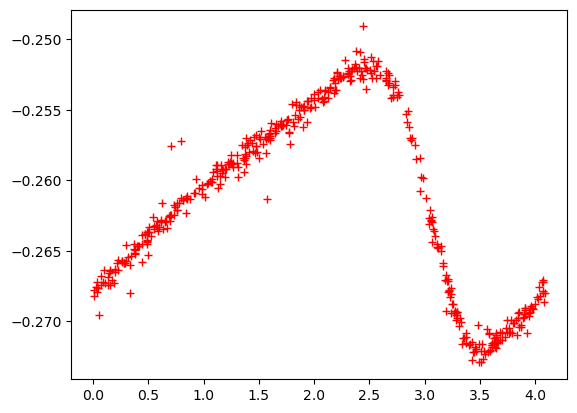

In [10]:
import matplotlib.pyplot as plt
plt.plot(X[200][0],X[200][1],'r+')

In [11]:
import aug
import torch

In [12]:
import random
rm = random.choice(aug.augment_pool())

In [114]:
def zero_masking(tensor):
    factor = 0.3
    largo = len(tensor[1])
    mask_len = int(largo * factor)
    mask = np.ones(largo,dtype=bool)
    start = int(random.randint(0,int(largo-mask_len)))
    end = int(start + mask_len)
    if end>largo:
        end = largo
    mask[ start:end  ] = False
    mask = torch.tensor(mask.astype(int))
    return [tensor[0],tensor[1] * mask]

In [115]:
curva = torch.tensor([X[200][0],X[200][1]])
augmented = zero_masking(curva)


ValueError: only one element tensors can be converted to Python scalars

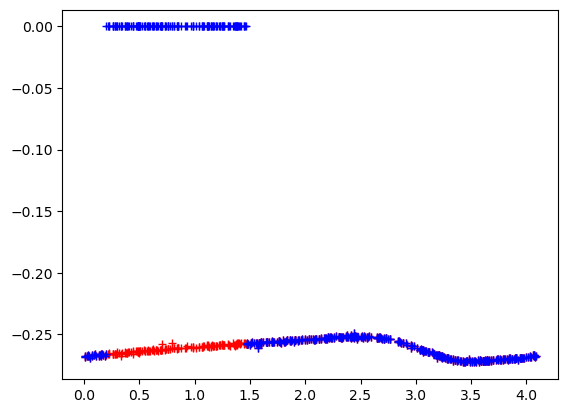

In [109]:
plt.plot(curva[0],curva[1],'r+')
plt.plot(augmented[0],augmented[1],'b+')